Plotting 99967 complete-lifecycle clouds out of 100000 total clouds


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_24189/1389915747.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('Set2', active_num_clouds)


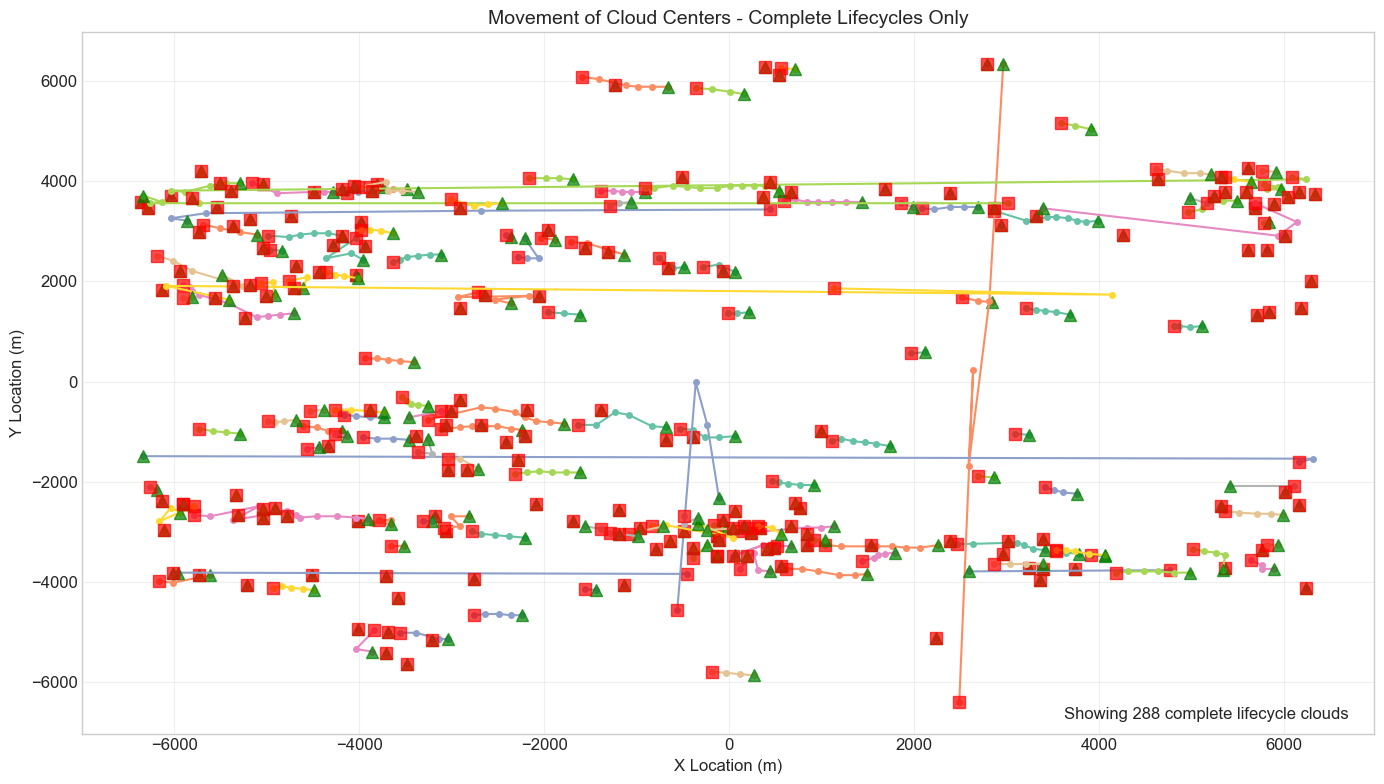

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import matplotlib.cm as cm

nc_file = '../cloud_results_temp.nc'  # Replace this with your actual NetCDF file path
dataset = Dataset(nc_file, 'r')

# Load valid_track to identify complete lifecycle clouds
valid_tracks = dataset.variables['valid_track'][:]  # 1 = complete lifecycle, 0 = partial lifecycle
full_lifecycle_mask = (valid_tracks == 1)
print(f"Plotting {np.sum(full_lifecycle_mask)} complete-lifecycle clouds out of {len(valid_tracks)} total clouds")

# Reading cloud center locations
x_centers = dataset.variables['location_x'][:]  
y_centers = dataset.variables['location_y'][:]

# Filter for clouds that have both valid data and complete lifecycles
valid_cloud_indices = (np.any(~np.isnan(x_centers), axis=1) & 
                        np.any(~np.isnan(y_centers), axis=1) & 
                        full_lifecycle_mask)
active_num_clouds = np.sum(valid_cloud_indices)  # Number of valid, full-lifecycle clouds

# Generate a color map for the active clouds
colors = cm.get_cmap('Set2', active_num_clouds)

# Plot for cloud center movements
plt.figure(figsize=(14, 8))
color_idx = 0  # To index into the colors array

for cloud_idx in range(len(valid_cloud_indices)):
    if valid_cloud_indices[cloud_idx]:  # Check if the cloud has valid data and is full lifecycle
        valid_idx = ~np.isnan(x_centers[cloud_idx, :]) & ~np.isnan(y_centers[cloud_idx, :])
        if np.any(valid_idx):  # Ensure there are valid points to plot
            # Find cloud track duration to label it
            track_duration = np.sum(valid_idx)
            
            # Plot the track with a label showing cloud ID and duration
            plt.plot(x_centers[cloud_idx, valid_idx], y_centers[cloud_idx, valid_idx], '-o', 
                    color=colors(color_idx), linewidth=1.5, markersize=4,
                    label=f'Cloud {cloud_idx+1} ({track_duration} steps)')
            
            # Optionally add start/end markers
            plt.plot(x_centers[cloud_idx, valid_idx][0], y_centers[cloud_idx, valid_idx][0], 'g^', 
                    markersize=8, alpha=0.7)  # Green triangle for start
            plt.plot(x_centers[cloud_idx, valid_idx][-1], y_centers[cloud_idx, valid_idx][-1], 'rs', 
                    markersize=8, alpha=0.7)  # Red square for end
            
            color_idx += 1  # Move to the next color for the next active cloud

plt.xlabel('X Location (m)', fontsize=12)
plt.ylabel('Y Location (m)', fontsize=12)
plt.title('Movement of Cloud Centers - Complete Lifecycles Only', fontsize=14)
plt.grid(True, alpha=0.3)

# Only show legend if there aren't too many clouds to keep it readable
if active_num_clouds <= 15:
    plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=10)
else:
    plt.text(0.98, 0.02, f"Showing {active_num_clouds} complete lifecycle clouds", 
             horizontalalignment='right', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

dataset.close()

# lifespan mass flux

# change in consideration of age

Analyzing 99610 complete-lifecycle clouds using inherited age...
Age statistics - Min: 1, Max: 23, Mean: 2.27


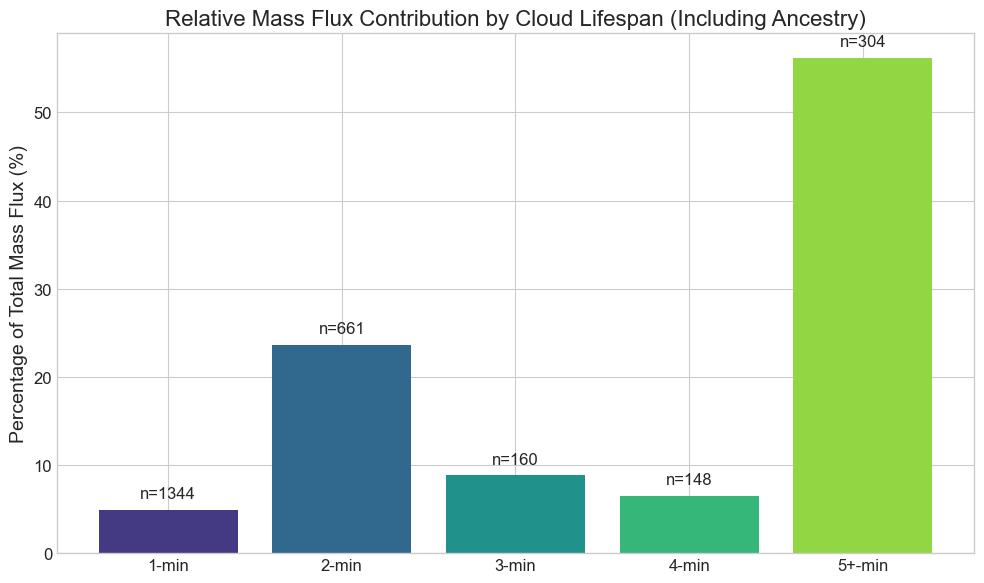

In [7]:
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import seaborn as sns

# --- 1. Data Loading and Preparation ---
nc_file = '../cloud_results.nc'

try:
    dataset = Dataset(nc_file, 'r')

    # Load necessary variables from the NetCDF file
    valid_tracks = dataset.variables['valid_track'][:]
    cloud_mass_flux_per_level = dataset.variables['mass_flux_per_level'][:]
    location_x = dataset.variables['location_x'][:]
    
    # Add this: Load age variable that contains inherited age information
    age_data = dataset.variables['age'][:]
    
    # Handle masked arrays if present
    if np.ma.is_masked(valid_tracks):
        valid_tracks = valid_tracks.filled(np.nan)
    if np.ma.is_masked(cloud_mass_flux_per_level):
        cloud_mass_flux_per_level = cloud_mass_flux_per_level.filled(np.nan)
    if np.ma.is_masked(location_x):
        location_x = location_x.filled(np.nan)
    if np.ma.is_masked(age_data):
        age_data = age_data.filled(-1)  # Fill masked values with -1 (invalid age)
    
    # --- 2. Calculate Lifespans and Mass Flux by Lifespan Category ---
    full_lifecycle_indices = np.where(valid_tracks == 1)[0]
    
    # Initialize data structures
    lifespans = []
    total_fluxes = []
    cloud_indices = []  # Store cloud indices for debugging
    
    print(f"Analyzing {len(full_lifecycle_indices)} complete-lifecycle clouds using inherited age...")
    
    for cloud_idx in full_lifecycle_indices:
        # Determine active timesteps for this cloud
        active_timesteps_mask = ~np.isnan(location_x[cloud_idx, :])
        
        if not np.any(active_timesteps_mask):
            continue
        
        cloud_indices.append(cloud_idx)
            
        # Use the maximum age value from the age variable instead of counting timesteps
        # Age starts at 0, so add 1 to get the true lifespan
        max_age = int(np.max(age_data[cloud_idx, active_timesteps_mask])) + 1
        lifespans.append(max_age)
        
        # Calculate total mass flux (sum over active timesteps and all levels)
        cloud_total_flux = np.nansum(cloud_mass_flux_per_level[cloud_idx, active_timesteps_mask, :])
        total_fluxes.append(cloud_total_flux)
    
    # Convert to numpy arrays
    cloud_indices = np.array(cloud_indices)
    lifespans = np.array(lifespans)
    total_fluxes = np.array(total_fluxes)
    
    # Print some statistics about the inherited ages
    print(f"Age statistics - Min: {np.min(lifespans)}, Max: {np.max(lifespans)}, Mean: {np.mean(lifespans):.2f}")
    
    # --- 3. Categorize clouds by lifespan based on inherited age ---
    categories = ['1-min', '2-min', '3-min', '4-min', '5+-min']
    category_indices = {
        '1-min': lifespans == 1,
        '2-min': lifespans == 2,
        '3-min': lifespans == 3,
        '4-min': lifespans == 4,
        '5+-min': lifespans >= 5
    }
    
    # Calculate flux and count per category
    category_fluxes = {}
    category_counts = {}
    for category, indices in category_indices.items():
        if np.any(indices):
            category_fluxes[category] = np.sum(total_fluxes[indices])
            category_counts[category] = np.sum(indices)
        else:
            category_fluxes[category] = 0
            category_counts[category] = 0
    
    # Calculate relative contributions
    total_flux = sum(category_fluxes.values())
    relative_contributions = {cat: flux/total_flux*100 if total_flux > 0 else 0 
                             for cat, flux in category_fluxes.items()}
    
    # --- 4. Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 6))
    
    bars = plt.bar(categories, [relative_contributions[cat] for cat in categories], 
                   color=sns.color_palette("viridis", len(categories)))
    
    plt.ylabel('Percentage of Total Mass Flux (%)', fontsize=14)
    plt.title('Relative Mass Flux Contribution by Cloud Lifespan (Including Ancestry)', fontsize=16)
    
    # Add count labels above bars
    for bar, cat in zip(bars, categories):
        count = category_counts[cat]
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'n={count}', ha='center', va='bottom', fontsize=12)
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

finally:
    if 'dataset' in locals():
        dataset.close()

Total clouds: 100000, Full lifecycle clouds: 99610
Found 2617 clouds with valid lifespans
Age statistics - Min: 1, Max: 23, Mean: 2.27
Cloud lifespan distribution (using inherited age):
  1-min: 1344 clouds
  2-min: 661 clouds
  3-min: 160 clouds
  4-min: 148 clouds
  5-min: 102 clouds
  6-min: 62 clouds
  7+-min: 140 clouds

Cloud categorization summary:
1-min: 1344 clouds, 159262720.00 total mass flux
2-min: 661 clouds, 768752896.00 total mass flux
3-min: 160 clouds, 287461856.00 total mass flux
4-min: 148 clouds, 212314016.00 total mass flux
5-min: 102 clouds, 206124448.00 total mass flux
6-min: 62 clouds, 236297968.00 total mass flux
7+-min: 140 clouds, 1386175104.00 total mass flux


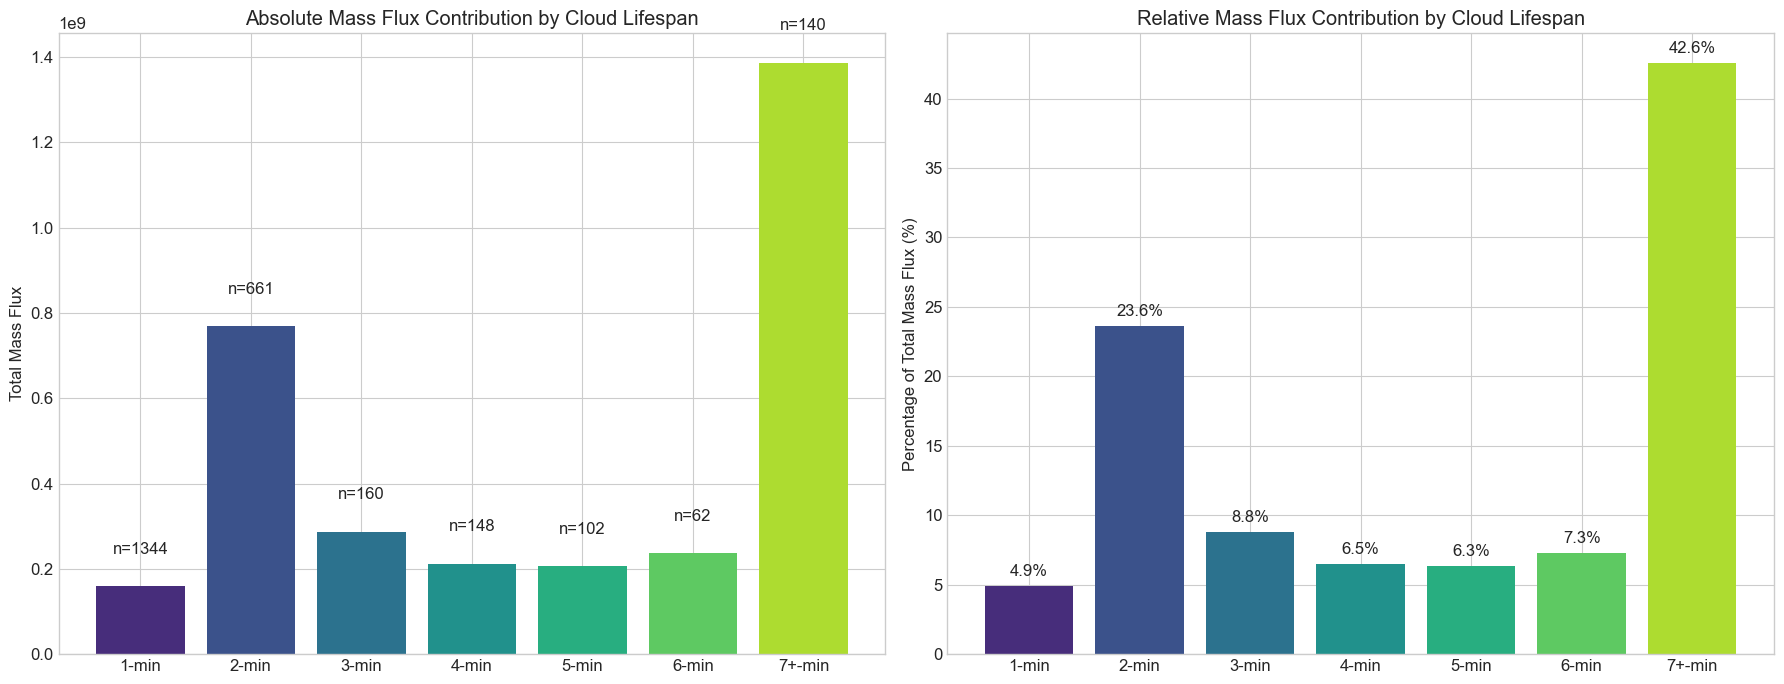

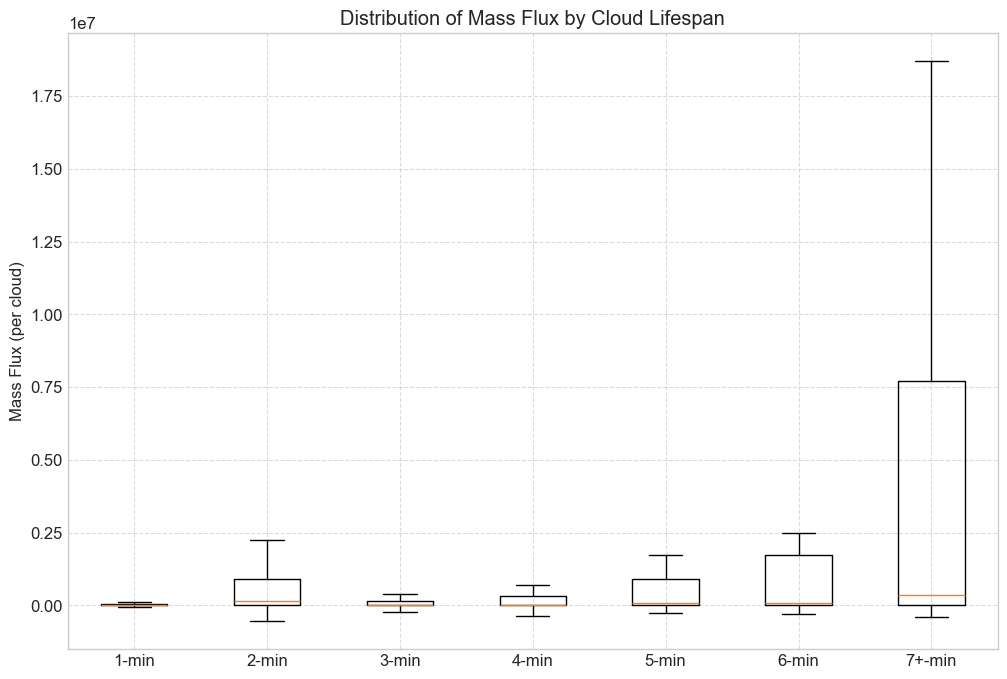

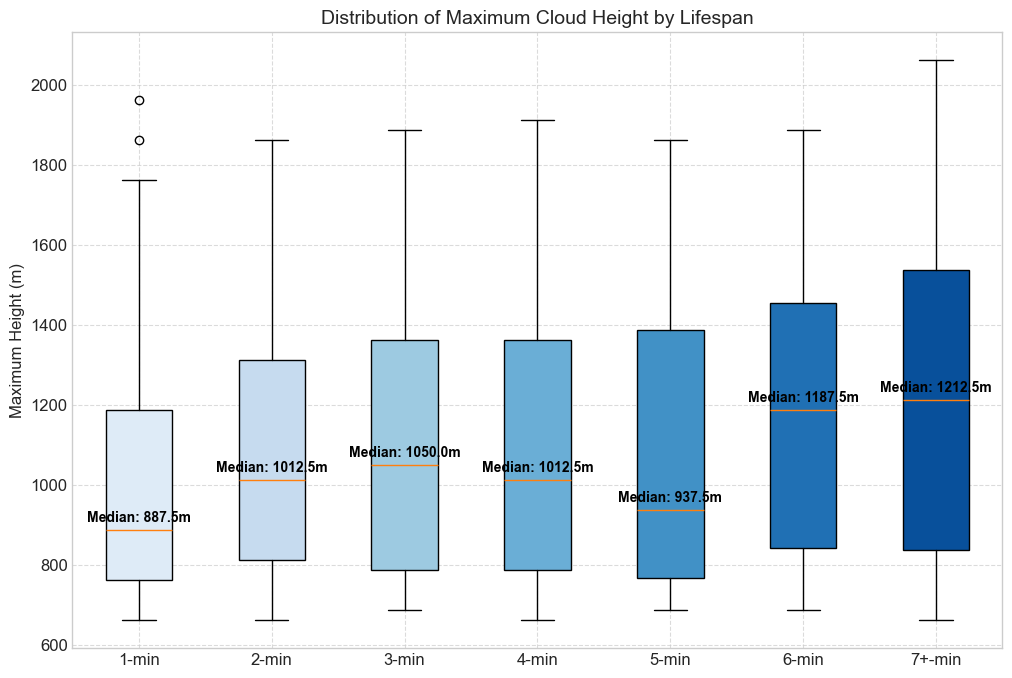

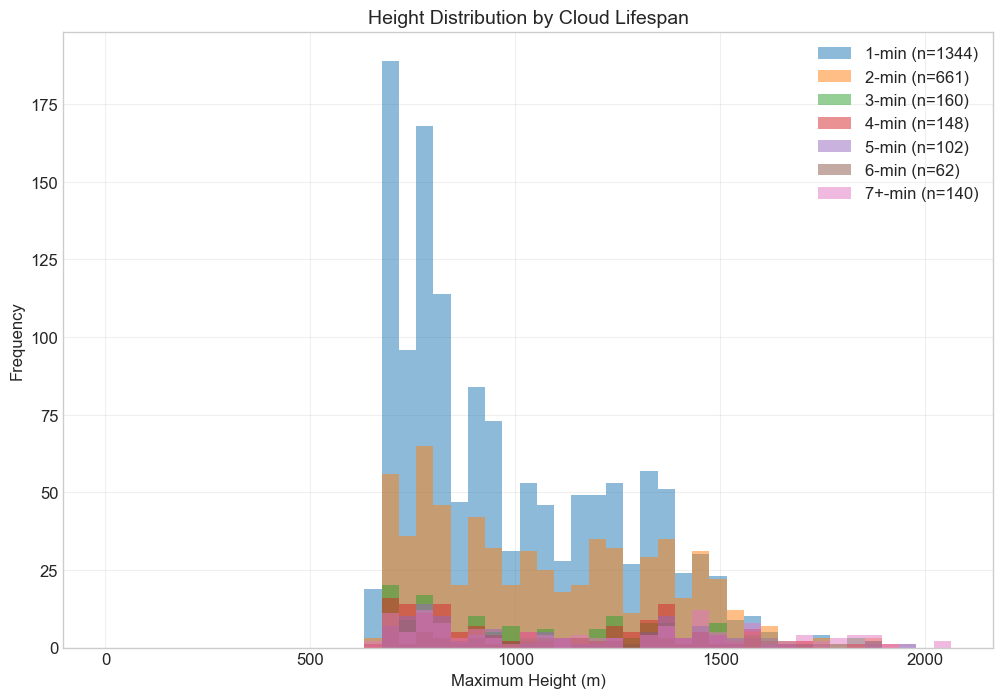

,Lifespan Category,Cloud Count,Percentage of Clouds,Total Mass Flux,Percentage of Mass Flux,Mean Mass Flux per Cloud,Mean Max Height (m),Median Max Height (m)
0,1-min,1344,51.4%,1.592627e+08,4.9%,118499.05,981.1,887.5
1,2-min,661,25.3%,7.687529e+08,23.6%,1163014.97,1066.4,1012.5
2,3-min,160,6.1%,2.874619e+08,8.8%,1796636.60,1095.0,1050.0
3,4-min,148,5.7%,2.123140e+08,6.5%,1434554.16,1072.5,1012.5
4,5-min,102,3.9%,2.061244e+08,6.3%,2020827.92,1064.7,937.5
5,6-min,62,2.4%,2.362980e+08,7.3%,3811257.55,1172.2,1187.5
6,7+-min,140,5.3%,1.386175e+09,42.6%,9901250.74,1223.8,1212.5


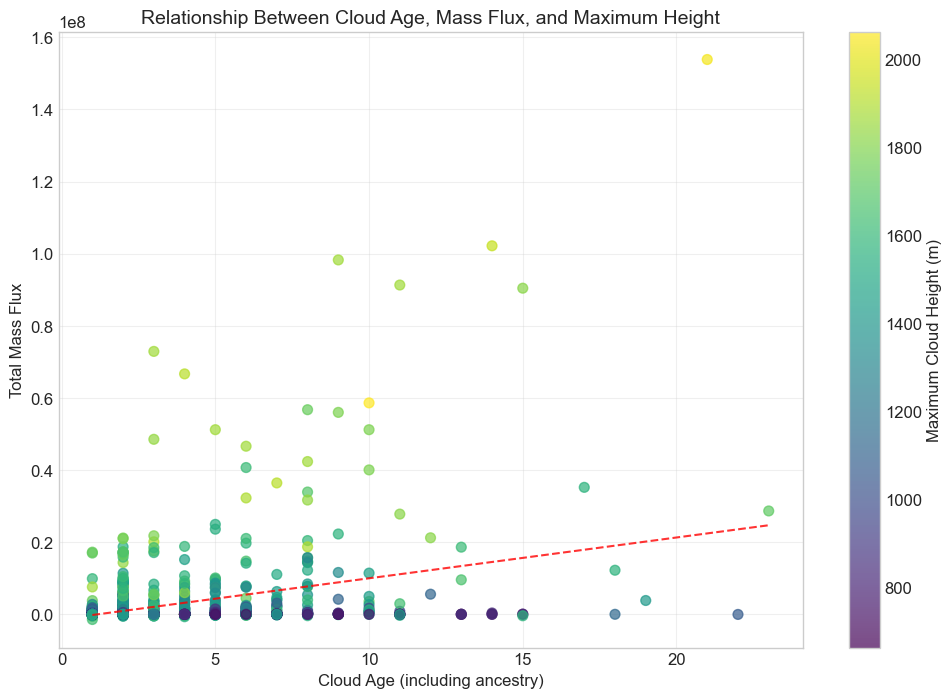

In [3]:
# Import necessary libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
import seaborn as sns
import pandas as pd

# Configure visualization style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

# Path to your NetCDF file
nc_file = '../cloud_results.nc'  # Update this path as needed

def load_cloud_data():
    """Load and filter cloud data for complete lifecycles only"""
    with Dataset(nc_file, 'r') as dataset:
        # Basic filtering variables
        valid_track = dataset.variables['valid_track'][:]
        
        # Handle masked arrays if present
        if np.ma.is_masked(valid_track):
            valid_track = valid_track.filled(np.nan)
            
        full_lifetime_indices = np.where(valid_track == 1)[0]
        print(f"Total clouds: {len(valid_track)}, Full lifecycle clouds: {len(full_lifetime_indices)}")
        
        # If no valid clouds, return early
        if len(full_lifetime_indices) == 0:
            return None
        
        # Load all necessary variables and filter for full lifecycles
        ages = dataset.variables['age'][:].T[:, full_lifetime_indices]
        sizes = dataset.variables['size'][:].T[:, full_lifetime_indices]
        mass_flux = dataset.variables['mass_flux'][:].T[:, full_lifetime_indices]
        max_height = dataset.variables['max_height'][:].T[:, full_lifetime_indices]
        
        # Convert masked arrays to arrays with NaNs
        def unmask_array(arr):
            """Convert masked arrays to normal arrays, filling masked values appropriately"""
            if np.ma.is_masked(arr):
                # For integer arrays, convert to float64 before filling with NaN
                if np.issubdtype(arr.dtype, np.integer):
                    return arr.astype(np.float64).filled(np.nan)
                else:
                    return arr.filled(np.nan)
            return arr
            
        ages = unmask_array(ages)
        sizes = unmask_array(sizes)
        mass_flux = unmask_array(mass_flux)
        max_height = unmask_array(max_height)
        
        # Optional: Load location_x for alternative lifespan calculation
        location_x = unmask_array(dataset.variables['location_x'][:].T[:, full_lifetime_indices])
        
        return {
            'ages': ages, 
            'sizes': sizes, 
            'mass_flux': mass_flux, 
            'max_height': max_height,
            'location_x': location_x,
            'indices': full_lifetime_indices
        }

# Load the data
cloud_data = load_cloud_data()
if cloud_data is None:
    print("No valid clouds found for analysis.")


def categorize_clouds_by_lifespan(cloud_data):
    """
    Categorize clouds by their lifespan using inherited age values from NetCDF
    """
    # Extract variables
    ages = cloud_data['ages']
    sizes = cloud_data['sizes']
    mass_flux = cloud_data['mass_flux']
    max_height = cloud_data['max_height']
    location_x = cloud_data['location_x']
    
    # Use the cloud age variable instead of counting active timesteps
    lifespans_array = []
    valid_cloud_indices = []
    
    for i in range(location_x.shape[1]):
        # Determine active timesteps for this cloud
        active_timesteps = ~np.isnan(location_x[:, i])
        if np.any(active_timesteps):
            # Get max age value for this cloud (adding 1 since age starts at 0)
            max_age = int(np.nanmax(ages[:, i][active_timesteps])) + 1
            lifespans_array.append(max_age)
            valid_cloud_indices.append(i)
    
    # Convert to numpy array
    lifespans_array = np.array(lifespans_array)
    valid_cloud_indices = np.array(valid_cloud_indices)
    
    # Filter data to include only clouds with valid lifespans
    filtered_mass_flux = mass_flux[:, valid_cloud_indices]
    filtered_max_height = max_height[:, valid_cloud_indices]
    filtered_location_x = location_x[:, valid_cloud_indices]
    
    print(f"Found {len(valid_cloud_indices)} clouds with valid lifespans")
    print(f"Age statistics - Min: {np.min(lifespans_array)}, Max: {np.max(lifespans_array)}, Mean: {np.mean(lifespans_array):.2f}")
    
    # Define lifespan categories
    categories = ['1-min', '2-min', '3-min', '4-min', '5+-min']
    category_indices = {
        '1-min': np.where(lifespans_array == 1)[0],
        '2-min': np.where(lifespans_array == 2)[0],
        '3-min': np.where(lifespans_array == 3)[0],
        '4-min': np.where(lifespans_array == 4)[0],
        '5-min': np.where(lifespans_array == 5)[0],
        '6-min': np.where(lifespans_array == 6)[0],
        '7+-min': np.where(lifespans_array >= 7)[0]
    }
    
    # Print lifespan distribution
    print("Cloud lifespan distribution (using inherited age):")
    for cat, indices in category_indices.items():
        print(f"  {cat}: {len(indices)} clouds")
    
    # Rest of the function remains the same...
    result = {}
    # For each category, extract relevant data
    for category, indices in category_indices.items():
        if len(indices) == 0:
            result[category] = {
                'count': 0,
                'total_mass_flux': 0,
                'mass_flux_values': np.array([]),
                'max_height_values': np.array([])
            }
            continue
        
        # Calculate category metrics
        category_total_fluxes = []
        category_max_heights = []
        
        for idx in indices:
            cloud_idx = valid_cloud_indices[idx]
            
            # Get active timesteps for this cloud
            active_timesteps = ~np.isnan(filtered_location_x[:, idx])
            
            # Calculate total mass flux for this cloud
            cloud_total_flux = np.nansum(filtered_mass_flux[:, idx][active_timesteps])
            category_total_fluxes.append(cloud_total_flux)
            
            # Calculate maximum height for this cloud
            cloud_max_height = np.nanmax(filtered_max_height[:, idx][active_timesteps])
            category_max_heights.append(cloud_max_height)
        
        # Convert to numpy arrays and filter out NaNs
        category_total_fluxes = np.array(category_total_fluxes)
        category_max_heights = np.array(category_max_heights)
        
        valid_flux = category_total_fluxes[~np.isnan(category_total_fluxes)]
        valid_height = category_max_heights[~np.isnan(category_max_heights)]
        
        result[category] = {
            'count': len(indices),
            'total_mass_flux': np.sum(valid_flux),
            'mass_flux_values': valid_flux,
            'max_height_values': valid_height
        }
    
    return result

# Categorize clouds
if cloud_data is not None:
    cloud_categories = categorize_clouds_by_lifespan(cloud_data)
    
    # Print summary of categorization
    print("\nCloud categorization summary:")
    for category, data in cloud_categories.items():
        print(f"{category}: {data['count']} clouds, {data['total_mass_flux']:.2f} total mass flux")

def plot_mass_flux_analysis(cloud_categories):
    """
    Create visualizations for mass flux analysis by cloud lifespan
    """
    # Extract key data for the plots
    categories = list(cloud_categories.keys())
    cloud_counts = [data['count'] for data in cloud_categories.values()]
    total_flux_values = [data['total_mass_flux'] for data in cloud_categories.values()]
    
    # Calculate relative contributions
    total_mass_flux = sum(total_flux_values)
    relative_contributions = [flux/total_mass_flux*100 if total_mass_flux > 0 else 0 
                             for flux in total_flux_values]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # Plot 1: Absolute mass flux by lifespan
    bars1 = ax1.bar(categories, total_flux_values, color=sns.color_palette("viridis", len(categories)))
    ax1.set_ylabel('Total Mass Flux')
    ax1.set_title('Absolute Mass Flux Contribution by Cloud Lifespan')
    
    # Add count labels to the bars
    for bar, count in zip(bars1, cloud_counts):
        if count > 0:  # Only add label if there are clouds in this category
            height = bar.get_height()
            max_value = max([v for v in total_flux_values if v > 0]) if any(v > 0 for v in total_flux_values) else 1
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.05*max_value,
                    f'n={count}', ha='center', va='bottom')
    
    # Plot 2: Relative mass flux contribution by lifespan
    bars2 = ax2.bar(categories, relative_contributions, color=sns.color_palette("viridis", len(categories)))
    ax2.set_ylabel('Percentage of Total Mass Flux (%)')
    ax2.set_title('Relative Mass Flux Contribution by Cloud Lifespan')
    
    # Add percentage labels to the bars
    for bar, pct in zip(bars2, relative_contributions):
        if pct > 0:  # Only add label if there's a contribution
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{pct:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Create an additional plot for mass flux distribution within categories
    non_empty_categories = [cat for cat, data in cloud_categories.items() 
                           if len(data['mass_flux_values']) > 0]
    
    if non_empty_categories:  # Only create boxplot if there are categories with data
        plt.figure(figsize=(12, 8))
        
        # Prepare data for box plots
        box_data = [data['mass_flux_values'] for cat, data in cloud_categories.items() 
                   if len(data['mass_flux_values']) > 0]
        valid_categories = [cat for cat, data in cloud_categories.items() 
                           if len(data['mass_flux_values']) > 0]
        
        # Create box plot
        plt.boxplot(box_data, labels=valid_categories, showfliers=False)
        plt.title('Distribution of Mass Flux by Cloud Lifespan')
        plt.ylabel('Mass Flux (per cloud)')
        plt.grid(True, linestyle='--', alpha=0.7)
        
        plt.show()

# Plot mass flux analysis
if cloud_data is not None:
    plot_mass_flux_analysis(cloud_categories)

def plot_height_distribution(cloud_categories):
    """
    Create visualizations for height distribution analysis by cloud lifespan
    """
    # Extract height data for each category
    height_data = {}
    for category, data in cloud_categories.items():
        if data['count'] > 0 and len(data['max_height_values']) > 0:
            height_data[category] = data['max_height_values']
    
    if not height_data:  # Check if there's any height data to plot
        print("No valid height data available for plotting")
        return
    
    # Plot 1: Box plot comparison of heights
    plt.figure(figsize=(12, 8))
    
    box_data = list(height_data.values())
    valid_categories = list(height_data.keys())
    
    # Create box plot
    box = plt.boxplot(box_data, labels=valid_categories, patch_artist=True)
    
    # Color the boxes based on lifespan
    colors = sns.color_palette("Blues", len(valid_categories))
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    plt.title('Distribution of Maximum Cloud Height by Lifespan', fontsize=14)
    plt.ylabel('Maximum Height (m)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add median values as text
    for i, category in enumerate(valid_categories):
        median = np.median(height_data[category])
        plt.text(i+1, median + 20, f'Median: {median:.1f}m', 
                 horizontalalignment='center', size='small', color='black', weight='semibold')
    
    plt.show()
    
    # Plot 2: Overlaid histograms
    if len(height_data) > 0:  # Only create histogram if there's data
        plt.figure(figsize=(12, 8))
        
        # Define a reasonable range for heights
        all_heights = np.concatenate(list(height_data.values()))
        max_height = np.max(all_heights)
        bins = np.linspace(0, max_height, 50)
        
        # Plot histograms
        for category, height_values in height_data.items():
            plt.hist(height_values, bins=bins, alpha=0.5, label=f'{category} (n={len(height_values)})')
        
        plt.title('Height Distribution by Cloud Lifespan', fontsize=14)
        plt.xlabel('Maximum Height (m)', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.show()

# Plot height distribution analysis
if cloud_data is not None:
    plot_height_distribution(cloud_categories)

def create_detailed_statistics(cloud_categories):
    """
    Generate detailed statistics table for cloud lifespan analysis
    """
    # Prepare data for the table
    data = {
        'Lifespan Category': [],
        'Cloud Count': [],
        'Percentage of Clouds': [],
        'Total Mass Flux': [],
        'Percentage of Mass Flux': [],
        'Mean Mass Flux per Cloud': [],
        'Mean Max Height (m)': [],
        'Median Max Height (m)': []
    }
    
    # Calculate totals for percentages
    total_clouds = sum(cat['count'] for cat in cloud_categories.values())
    total_mass_flux = sum(cat['total_mass_flux'] for cat in cloud_categories.values())
    
    # Fill the data dictionary
    for category, cat_data in cloud_categories.items():
        data['Lifespan Category'].append(category)
        data['Cloud Count'].append(cat_data['count'])
        data['Percentage of Clouds'].append(cat_data['count'] / total_clouds * 100 if total_clouds > 0 else 0)
        data['Total Mass Flux'].append(cat_data['total_mass_flux'])
        data['Percentage of Mass Flux'].append(cat_data['total_mass_flux'] / total_mass_flux * 100 if total_mass_flux > 0 else 0)
        
        # Calculate mean mass flux per cloud
        if cat_data['count'] > 0:
            data['Mean Mass Flux per Cloud'].append(cat_data['total_mass_flux'] / cat_data['count'])
            data['Mean Max Height (m)'].append(np.mean(cat_data['max_height_values']) if len(cat_data['max_height_values']) > 0 else np.nan)
            data['Median Max Height (m)'].append(np.median(cat_data['max_height_values']) if len(cat_data['max_height_values']) > 0 else np.nan)
        else:
            data['Mean Mass Flux per Cloud'].append(np.nan)
            data['Mean Max Height (m)'].append(np.nan)
            data['Median Max Height (m)'].append(np.nan)
    
    # Create DataFrame and display
    df = pd.DataFrame(data)
    
    # Format the DataFrame for display
    formatted_df = df.copy()
    formatted_df['Percentage of Clouds'] = formatted_df['Percentage of Clouds'].map(lambda x: f'{x:.1f}%')
    formatted_df['Percentage of Mass Flux'] = formatted_df['Percentage of Mass Flux'].map(lambda x: f'{x:.1f}%')
    formatted_df['Mean Mass Flux per Cloud'] = formatted_df['Mean Mass Flux per Cloud'].map(lambda x: f'{x:.2f}' if not np.isnan(x) else 'N/A')
    formatted_df['Mean Max Height (m)'] = formatted_df['Mean Max Height (m)'].map(lambda x: f'{x:.1f}' if not np.isnan(x) else 'N/A')
    formatted_df['Median Max Height (m)'] = formatted_df['Median Max Height (m)'].map(lambda x: f'{x:.1f}' if not np.isnan(x) else 'N/A')
    
    return formatted_df

# Generate and display detailed statistics
if cloud_data is not None:
    detailed_stats = create_detailed_statistics(cloud_categories)
    display(detailed_stats)


def analyze_correlations(cloud_data):
    """
    Analyze correlations between cloud lifespan, mass flux, and height
    """
    # Extract necessary data
    location_x = cloud_data['location_x']
    mass_flux = cloud_data['mass_flux']
    max_height = cloud_data['max_height']
    ages = cloud_data['ages']  # Get the ages data
    
    # Calculate metrics for each cloud
    lifespans = []
    total_flux_values = []
    max_height_values = []
    
    for i in range(location_x.shape[1]):
        # Determine active timesteps for this cloud
        active_timesteps = ~np.isnan(location_x[:, i])
        
        if np.any(active_timesteps):
            # Calculate lifespan using max age instead of counting timesteps
            max_age = int(np.nanmax(ages[:, i][active_timesteps])) + 1
            lifespans.append(max_age)
            
            # Calculate total mass flux
            cloud_flux = np.nansum(mass_flux[:, i][active_timesteps])
            total_flux_values.append(cloud_flux)
            
            # Calculate maximum height
            cloud_height = np.nanmax(max_height[:, i][active_timesteps])
            max_height_values.append(cloud_height)
    
    # Convert to numpy arrays
    lifespans = np.array(lifespans)
    total_flux_values = np.array(total_flux_values)
    max_height_values = np.array(max_height_values)
    
    # Filter out NaN values
    valid_indices = ~(np.isnan(lifespans) | np.isnan(total_flux_values) | np.isnan(max_height_values))
    lifespans = lifespans[valid_indices]
    total_flux_values = total_flux_values[valid_indices]
    max_height_values = max_height_values[valid_indices]
    
    if len(lifespans) == 0:
        print("No valid correlation data available")
        return
    
    # Create scatter plot: Lifespan vs Mass Flux
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(lifespans, total_flux_values, c=max_height_values, 
                         cmap='viridis', alpha=0.7, s=50)
    
    plt.colorbar(scatter, label='Maximum Cloud Height (m)')
    plt.xlabel('Cloud Age (including ancestry)', fontsize=12)
    plt.ylabel('Total Mass Flux', fontsize=12)
    plt.title('Relationship Between Cloud Age, Mass Flux, and Maximum Height', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # Add trendline if there are sufficient points
    if len(lifespans) > 1:
        z = np.polyfit(lifespans, total_flux_values, 1)
        p = np.poly1d(z)
        unique_lifespans = np.unique(lifespans)
        plt.plot(unique_lifespans, p(unique_lifespans), "r--", alpha=0.8)
    
    plt.show()

# Analyze correlations
if cloud_data is not None:
    analyze_correlations(cloud_data)

# Height distrbution only per lifetime only

# Cloud top and base


Total clouds: 100000, Full lifecycle clouds: 99610


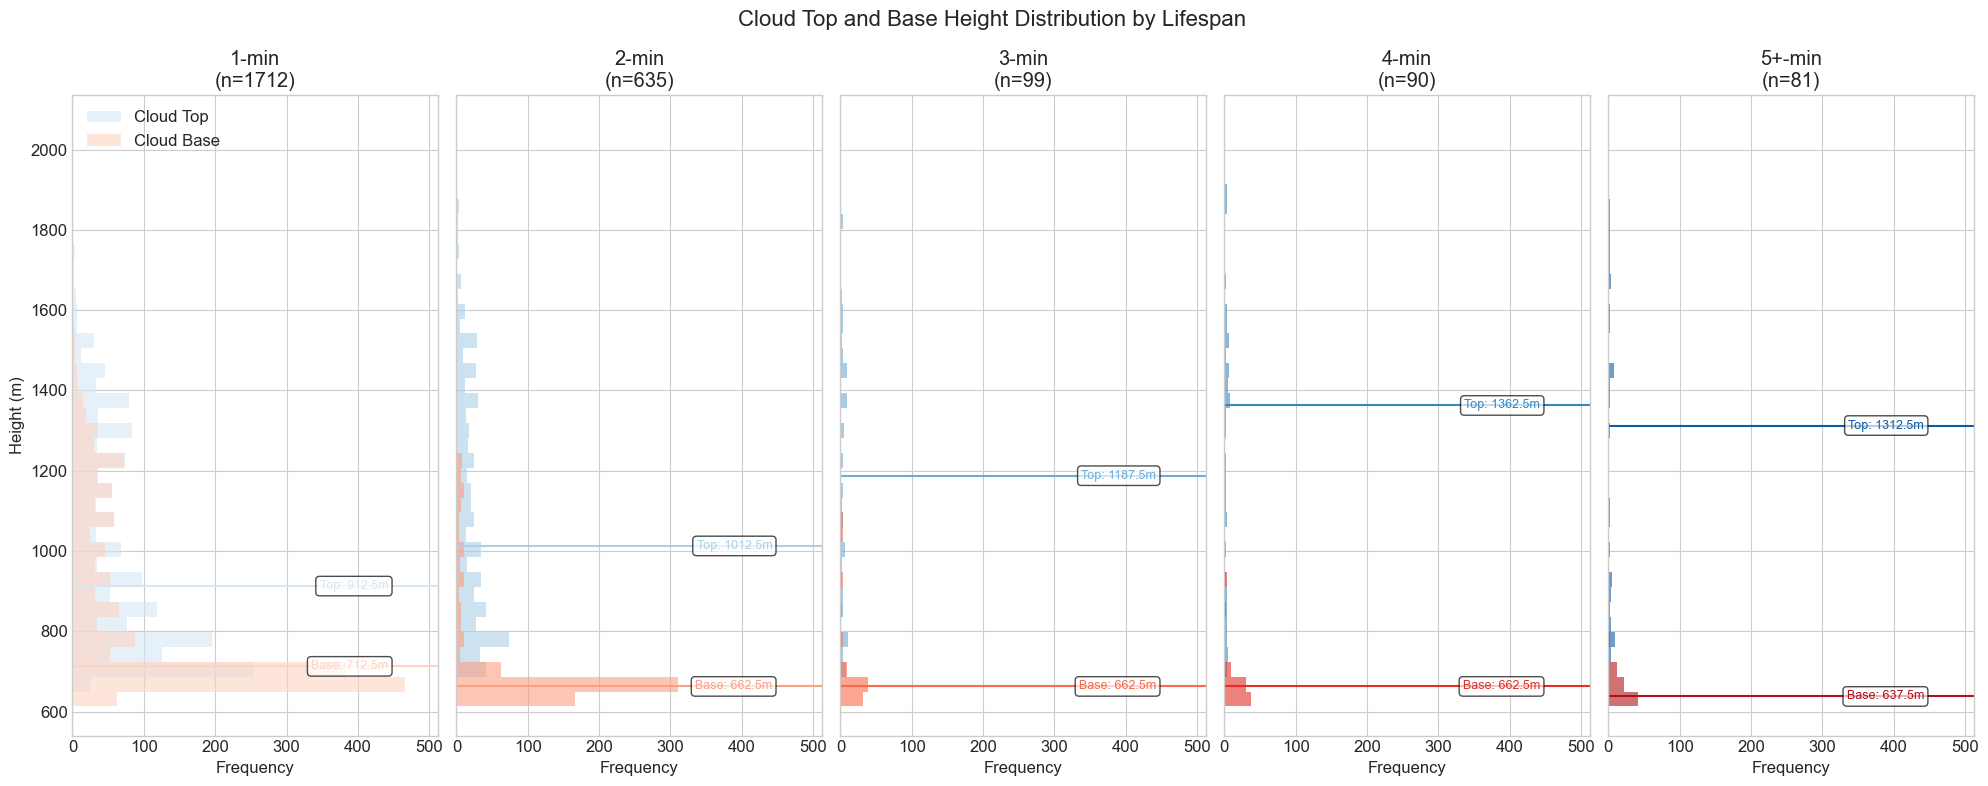

In [4]:
def plot_side_by_side_height_histograms(cloud_categories):
    """
    Create side-by-side horizontal histograms showing height distribution by cloud lifespan
    with both cloud top and cloud base heights
    """
    # Extract height data for each category
    height_data = {}
    for category, data in cloud_categories.items():
        if data['count'] > 0 and len(data['max_height_values']) > 0:
            height_data[category] = {
                'top': data['max_height_values'],
                'base': data['min_height_values'] if 'min_height_values' in data else np.zeros_like(data['max_height_values'])
            }
    
    if not height_data:
        print("No valid height data available for plotting")
        return
    
    # Sort categories properly
    valid_categories = list(height_data.keys())
    category_order = {'1-min': 0, '2-min': 1, '3-min': 2, '4-min': 3, '5+-min': 4}
    valid_categories.sort(key=lambda x: category_order.get(x, 999))
    
    # Calculate the number of plots needed
    n_plots = len(valid_categories)
    
    # Create a figure with subplots arranged horizontally
    fig, axes = plt.subplots(1, n_plots, figsize=(4*n_plots, 8), sharey=True)
    
    # Find overall height range for consistent y-axis
    all_heights_top = np.concatenate([height_data[cat]['top'] for cat in valid_categories])
    all_heights_base = np.concatenate([height_data[cat]['base'] for cat in valid_categories])
    all_heights = np.concatenate([all_heights_top, all_heights_base])
    
    max_height = np.max(all_heights_top)  # Use top heights for upper bound
    min_height = np.min(all_heights_base)  # Use base heights for lower bound
    
    # Create bins for histograms
    bins = np.linspace(min_height, max_height, 40)
    
    # Create color palettes
    top_color_palette = sns.color_palette("Blues", n_plots)
    base_color_palette = sns.color_palette("Reds", n_plots)
    
    # Track maximum frequency for consistent x-axis scaling
    max_count = 0
    
    # First pass to determine maximum frequency across both distributions
    for i, category in enumerate(valid_categories):
        top_heights = height_data[category]['top']
        base_heights = height_data[category]['base']
        
        top_counts, _ = np.histogram(top_heights, bins=bins)
        base_counts, _ = np.histogram(base_heights, bins=bins)
        
        max_count = max(max_count, np.max(top_counts), np.max(base_counts))
    
    # Create histograms for each category
    for i, category in enumerate(valid_categories):
        # Get data for this category
        top_heights = height_data[category]['top']
        base_heights = height_data[category]['base']
        
        # Get the axis to plot on
        ax = axes[i] if n_plots > 1 else axes
        
        # Plot horizontal histogram for cloud tops
        ax.hist(
            top_heights, bins=bins, orientation='horizontal',
            alpha=0.6, color=top_color_palette[i], label='Cloud Top'
        )
        
        # Plot horizontal histogram for cloud bases
        ax.hist(
            base_heights, bins=bins, orientation='horizontal',
            alpha=0.6, color=base_color_palette[i], label='Cloud Base'
        )
        
        # Add median lines
        top_median = np.median(top_heights)
        base_median = np.median(base_heights)
        
        ax.axhline(y=top_median, color=top_color_palette[i], linestyle='-', linewidth=1.5)
        ax.axhline(y=base_median, color=base_color_palette[i], linestyle='-', linewidth=1.5)
        
        # Add median labels
        ax.text(
            max_count * 0.95, top_median, 
            f'Top: {top_median:.1f}m',
            va='center', ha='right', fontsize=9, color=top_color_palette[i],
            bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
        )
        
        ax.text(
            max_count * 0.95, base_median, 
            f'Base: {base_median:.1f}m',
            va='center', ha='right', fontsize=9, color=base_color_palette[i],
            bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
        )
        
        # Set plot limits
        ax.set_xlim(0, max_count * 1.1)
        
        # Add labels
        ax.set_title(f"{category}\n(n={len(top_heights)})")
        ax.set_xlabel('Frequency')
        
        # Only add y-label and legend to the leftmost plot
        if i == 0:
            ax.set_ylabel('Height (m)')
            ax.legend(loc='upper left')
        
    # Add overall title
    plt.suptitle('Cloud Top and Base Height Distribution by Lifespan', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.05)  # Reduce horizontal space between plots
    plt.show()




def categorize_clouds_by_lifespan(cloud_data): 
    """
    Categorize clouds by their lifespan and prepare analysis data
    """
    # Extract variables
    ages = cloud_data['ages']
    sizes = cloud_data['sizes']
    mass_flux = cloud_data['mass_flux']
    max_height = cloud_data['max_height']
    location_x = cloud_data['location_x']
    
    # Load min_height if available, otherwise add code to load it
    # This assumes min_height was loaded in load_cloud_data()
    min_height = cloud_data.get('min_height', None)
    
    # If min_height is not available, we'll need to add code to load it
    # For this example, let's assume min_height is available
    
    # Calculate lifespan for each cloud using active timesteps
    lifespans_array = []
    valid_cloud_indices = []
    
    for i in range(location_x.shape[1]):
        active_timesteps = ~np.isnan(location_x[:, i])
        if np.any(active_timesteps):
            lifetime = np.sum(active_timesteps)
            lifespans_array.append(lifetime)
            valid_cloud_indices.append(i)
    
    # Convert to numpy array
    lifespans_array = np.array(lifespans_array)
    valid_cloud_indices = np.array(valid_cloud_indices)
    
    # Filter data to include only clouds with valid lifespans
    filtered_mass_flux = mass_flux[:, valid_cloud_indices]
    filtered_max_height = max_height[:, valid_cloud_indices]
    filtered_min_height = min_height[:, valid_cloud_indices] if min_height is not None else None
    filtered_location_x = location_x[:, valid_cloud_indices]
    
    # Define lifespan categories
    categories = ['1-min', '2-min', '3-min', '4-min', '5+-min']
    category_indices = {
        '1-min': np.where(lifespans_array == 1)[0],
        '2-min': np.where(lifespans_array == 2)[0],
        '3-min': np.where(lifespans_array == 3)[0],
        '4-min': np.where(lifespans_array == 4)[0],
        '5+-min': np.where(lifespans_array >= 5)[0]
    }
    
    result = {}
    # For each category, extract relevant data
    for category, indices in category_indices.items():
        if len(indices) == 0:
            result[category] = {
                'count': 0,
                'total_mass_flux': 0,
                'mass_flux_values': np.array([]),
                'max_height_values': np.array([]),
                'min_height_values': np.array([])
            }
            continue
        
        # Calculate category metrics
        category_total_fluxes = []
        category_max_heights = []
        category_min_heights = []
        
        for idx in indices:
            cloud_idx = valid_cloud_indices[idx]
            
            # Get active timesteps for this cloud
            active_timesteps = ~np.isnan(filtered_location_x[:, idx])
            
            # Calculate total mass flux for this cloud
            cloud_total_flux = np.nansum(filtered_mass_flux[:, idx][active_timesteps])
            category_total_fluxes.append(cloud_total_flux)
            
            # Calculate maximum height for this cloud
            cloud_max_height = np.nanmax(filtered_max_height[:, idx][active_timesteps])
            category_max_heights.append(cloud_max_height)
            
            # Calculate minimum height for this cloud if available
            if filtered_min_height is not None:
                cloud_min_height = np.nanmin(filtered_min_height[:, idx][active_timesteps])
                category_min_heights.append(cloud_min_height)
        
        # Convert to numpy arrays and filter out NaNs
        category_total_fluxes = np.array(category_total_fluxes)
        category_max_heights = np.array(category_max_heights)
        category_min_heights = np.array(category_min_heights) if filtered_min_height is not None else np.zeros_like(category_max_heights)
        
        valid_flux = category_total_fluxes[~np.isnan(category_total_fluxes)]
        valid_max_height = category_max_heights[~np.isnan(category_max_heights)]
        valid_min_height = category_min_heights[~np.isnan(category_min_heights)] if filtered_min_height is not None else np.zeros_like(valid_max_height)
        
        result[category] = {
            'count': len(indices),
            'total_mass_flux': np.sum(valid_flux),
            'mass_flux_values': valid_flux,
            'max_height_values': valid_max_height,
            'min_height_values': valid_min_height
        }
    
    return result


def load_cloud_data():
    """Load and filter cloud data for complete lifecycles only"""
    with Dataset(nc_file, 'r') as dataset:
        # Basic filtering variables
        valid_track = dataset.variables['valid_track'][:]
        
        # Handle masked arrays if present
        if np.ma.is_masked(valid_track):
            valid_track = valid_track.filled(np.nan)
            
        full_lifetime_indices = np.where(valid_track == 1)[0]
        print(f"Total clouds: {len(valid_track)}, Full lifecycle clouds: {len(full_lifetime_indices)}")
        
        # If no valid clouds, return early
        if len(full_lifetime_indices) == 0:
            return None
        
        # Load all necessary variables and filter for full lifecycles
        ages = dataset.variables['age'][:].T[:, full_lifetime_indices]
        sizes = dataset.variables['size'][:].T[:, full_lifetime_indices]
        mass_flux = dataset.variables['mass_flux'][:].T[:, full_lifetime_indices]
        max_height = dataset.variables['max_height'][:].T[:, full_lifetime_indices]
        
        # Load cloud_base_height directly - this is the correct variable name
        cloud_base_height = dataset.variables['cloud_base_height'][:].T[:, full_lifetime_indices]
        
        # Convert masked arrays to arrays with NaNs
        def unmask_array(arr):
            """Convert masked arrays to normal arrays, filling masked values appropriately"""
            if np.ma.is_masked(arr):
                if np.issubdtype(arr.dtype, np.integer):
                    return arr.astype(np.float64).filled(np.nan)
                else:
                    return arr.filled(np.nan)
            return arr
            
        ages = unmask_array(ages)
        sizes = unmask_array(sizes)
        mass_flux = unmask_array(mass_flux)
        max_height = unmask_array(max_height)
        cloud_base_height = unmask_array(cloud_base_height)
        
        # Optional: Load location_x for alternative lifespan calculation
        location_x = unmask_array(dataset.variables['location_x'][:].T[:, full_lifetime_indices])
        
        return {
            'ages': ages, 
            'sizes': sizes, 
            'mass_flux': mass_flux, 
            'max_height': max_height,
            'min_height': cloud_base_height,  # For compatibility with plotting function
            'cloud_base_height': cloud_base_height,  # Also provide with correct name
            'location_x': location_x,
            'indices': full_lifetime_indices
        }


# Load the data
cloud_data = load_cloud_data()
if cloud_data is not None:
    cloud_categories = categorize_clouds_by_lifespan(cloud_data)
    plot_side_by_side_height_histograms(cloud_categories)

Analyzing 99610 complete-lifecycle clouds...


<Figure size 1400x1000 with 0 Axes>

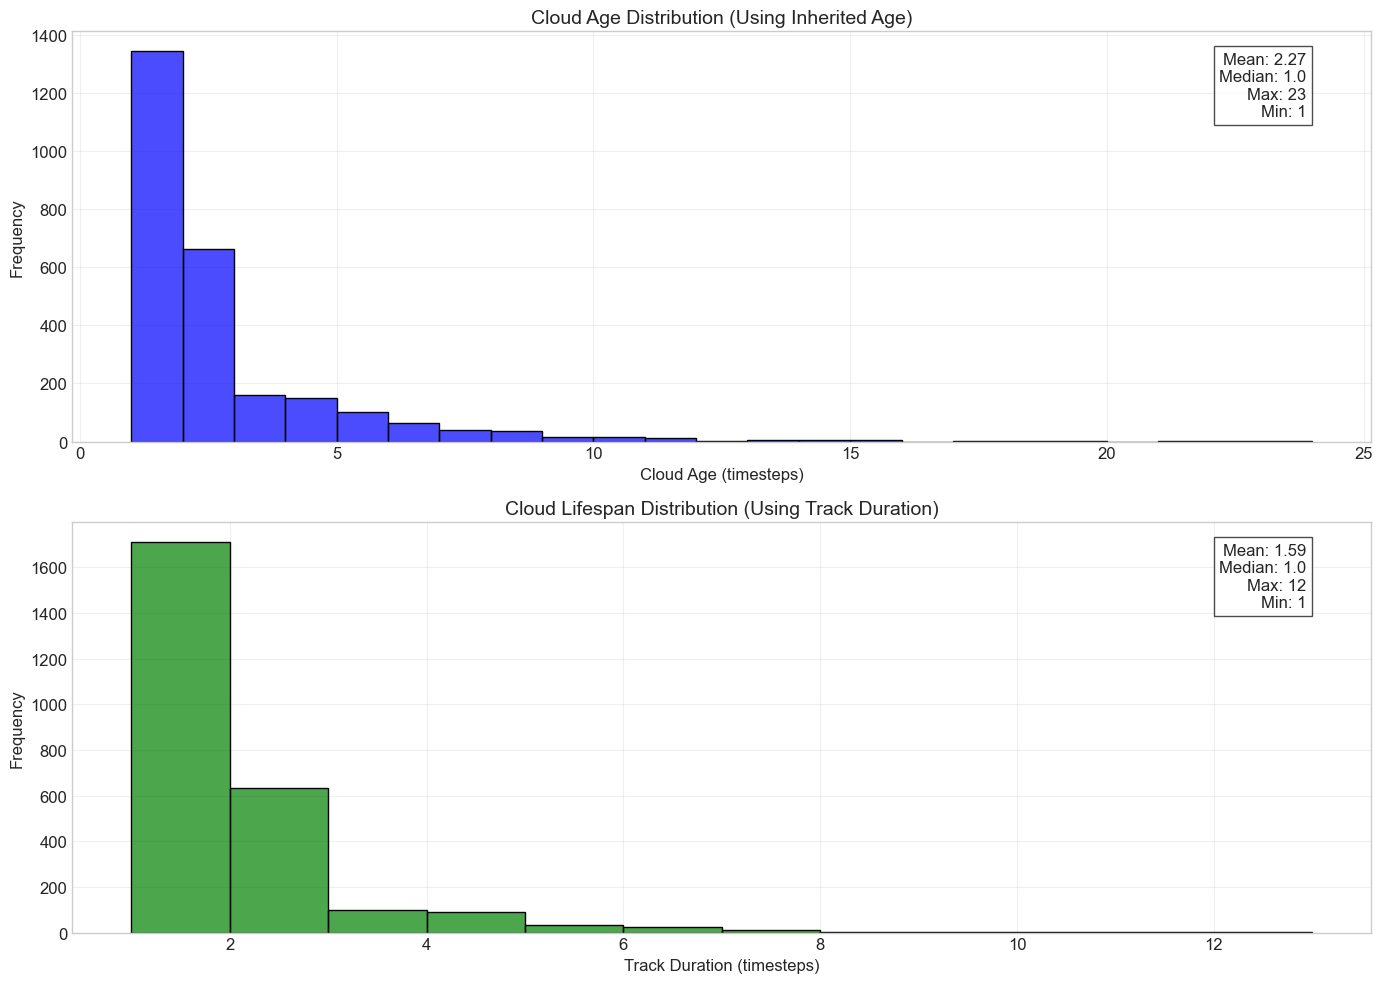


Summary Statistics:
Metric               Mean       Median     Min        Max       
------------------------------------------------------------
Inherited Age        2.27       1.0        1          23        
Track Duration       1.59       1.0        1          12        

Clouds with inherited age: 637 (24.3% of valid clouds)

Sample of clouds with significant age inheritance:
Cloud ID   Max Age    Track Duration  Inheritance
--------------------------------------------------
440        7          3               4         
465        4          1               3         
488        7          2               5         
525        5          2               3         
575        21         12              9         


In [6]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
import seaborn as sns
import pandas as pd

# Set figure styles
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 10))

# Path to your NetCDF file
nc_file = '../cloud_results.nc'  # Modify this path as needed

with Dataset(nc_file, 'r') as dataset:
    # Get valid track information
    valid_tracks = dataset.variables['valid_track'][:]
    full_lifecycle_indices = np.where(valid_tracks == 1)[0]
    
    print(f"Analyzing {len(full_lifecycle_indices)} complete-lifecycle clouds...")
    
    # Load age variable and location_x (to determine active timesteps)
    # Handle masked arrays if present
    age_data = dataset.variables['age'][:]
    location_x = dataset.variables['location_x'][:]
    
    if np.ma.is_masked(age_data):
        age_data = age_data.filled(-1)  # Fill masked values with -1 (the default fill value)
    if np.ma.is_masked(location_x):
        location_x = location_x.filled(np.nan)
    
    # Calculate metrics for each valid cloud
    max_ages = []        # Maximum age value (from age variable)
    track_durations = [] # Calculated track duration (from active timesteps)
    cloud_indices = []   # Store cloud indices for reference
    
    for cloud_idx in full_lifecycle_indices:
        # Determine active timesteps for this cloud
        active_timesteps = ~np.isnan(location_x[cloud_idx, :])
        
        if not np.any(active_timesteps):
            continue
        
        cloud_indices.append(cloud_idx)
        
        # Method 1: Get the maximum age value from the age variable
        # Note: Age starts at 0, so add 1 to get the true lifespan
        max_age = int(np.max(age_data[cloud_idx, active_timesteps])) + 1
        max_ages.append(max_age)
        
        # Method 2: Calculate track duration by counting active timesteps
        duration = np.sum(active_timesteps)
        track_durations.append(duration)
    
    # Create comparison plots
    plt.figure(figsize=(14, 10))
    
    # Plot 1: Max Age Distribution (from age variable including inheritance)
    plt.subplot(2, 1, 1)
    sns.histplot(max_ages, bins=range(1, max(max_ages)+2), 
                 kde=False, color='blue', alpha=0.7)
    plt.title('Cloud Age Distribution (Using Inherited Age)', fontsize=14)
    plt.xlabel('Cloud Age (timesteps)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add statistics
    plt.text(0.95, 0.95, 
             f"Mean: {np.mean(max_ages):.2f}\nMedian: {np.median(max_ages):.1f}\n"
             f"Max: {np.max(max_ages)}\nMin: {np.min(max_ages)}",
             transform=plt.gca().transAxes, 
             horizontalalignment='right',
             verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.7))
    
    # Plot 2: Track Duration Distribution (calculated from active timesteps)
    plt.subplot(2, 1, 2)
    sns.histplot(track_durations, bins=range(1, max(track_durations)+2), 
                kde=False, color='green', alpha=0.7)
    plt.title('Cloud Lifespan Distribution (Using Track Duration)', fontsize=14)
    plt.xlabel('Track Duration (timesteps)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add statistics
    plt.text(0.95, 0.95, 
             f"Mean: {np.mean(track_durations):.2f}\nMedian: {np.median(track_durations):.1f}\n"
             f"Max: {np.max(track_durations)}\nMin: {np.min(track_durations)}",
             transform=plt.gca().transAxes, 
             horizontalalignment='right',
             verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary information
    print("\nSummary Statistics:")
    print(f"{'Metric':<20} {'Mean':<10} {'Median':<10} {'Min':<10} {'Max':<10}")
    print("-" * 60)
    print(f"{'Inherited Age':<20} {np.mean(max_ages):<10.2f} {np.median(max_ages):<10.1f} "
          f"{np.min(max_ages):<10d} {np.max(max_ages):<10d}")
    print(f"{'Track Duration':<20} {np.mean(track_durations):<10.2f} {np.median(track_durations):<10.1f} "
          f"{np.min(track_durations):<10d} {np.max(track_durations):<10d}")
    
    # Calculate and display the difference
    age_diff = np.array(max_ages) - np.array(track_durations)
    inheritance_count = np.sum(age_diff > 0)
    print(f"\nClouds with inherited age: {inheritance_count} ({inheritance_count/len(max_ages)*100:.1f}% of valid clouds)")
    
    # Show a sample of clouds with significant age inheritance
    if inheritance_count > 0:
        significant_inheritance = np.where(age_diff > 2)[0]  # Clouds with 3+ timesteps inherited
        if len(significant_inheritance) > 0:
            print("\nSample of clouds with significant age inheritance:")
            print(f"{'Cloud ID':<10} {'Max Age':<10} {'Track Duration':<15} {'Inheritance':<10}")
            print("-" * 50)
            for i in significant_inheritance[:5]:  # Show first 5 examples
                idx = cloud_indices[i]
                print(f"{idx:<10d} {max_ages[i]:<10d} {track_durations[i]:<15d} {age_diff[i]:<10d}")